In [1]:
from py2neo import Graph, Node, Relationship
from neo4j import GraphDatabase
from pycparser.ply.ctokens import tokens
from sympy.physics.units import temperature
from torch_geometric.utils import negative_sampling
import random
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

D:\Ki 9\AKE\project-ky-9\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
graph = Graph("neo4j://127.0.0.1:7687", auth=("neo4j", "12345678"))

In [3]:
results = graph.query(
"""MATCH (c:CayTrong {name: "sầu riêng"})-[:BI_MAC]->(b:Benh)
RETURN c, b
LIMIT 50
""")
results

c,b
(_1073:CayTrong {name: 's\u1ea7u ri\u00eang'}),(_1074:Benh {name: 'ph\u1ea5n tr\u1eafng'})
(_1073:CayTrong {name: 's\u1ea7u ri\u00eang'}),(_1079:Benh {name: 'kh\u00f4 c\u00e0nh'})
(_1073:CayTrong {name: 's\u1ea7u ri\u00eang'}),(_1085:Benh {name: 'l\u1edf c\u1ed5 r\u1ec5'})


In [4]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))

In [14]:
def get_graph_data():
    with driver.session() as session:

        # Lấy tất cả các node thuộc các loại trong dự án
        nodes_query = """
        MATCH (n)
        WHERE n:CayTrong OR n:Benh OR n:NguyenNhan OR n:TrieuChung OR n:DieuTri
        RETURN id(n) AS node_id,
               labels(n)[0] AS label,
               coalesce(n.name, n.desc, 'NoName') AS display_name
        """
        nodes = session.run(nodes_query)

        # Tạo mapping: neo4j_id → {'label':..., 'name':...}
        node_mapping = {
            record["node_id"]: {
                "label": record["label"],
                "name": record["display_name"]
            }
            for record in nodes
        }

        # Lấy tất cả các quan hệ trong dự án
        edges_query = """
        MATCH (n)-[r]->(m)
        WHERE n:CayTrong OR n:Benh OR n:NguyenNhan OR n:TrieuChung OR n:DieuTri
        RETURN id(n) AS source,
               id(m) AS target,
               type(r) AS relationship_type
        """
        edges = session.run(edges_query)
        edge_list = [
            (record["source"], record["target"], record["relationship_type"])
            for record in edges
        ]

        # Lấy danh sách loại quan hệ
        unique_relationship_types = {e[2] for e in edge_list}

        return node_mapping, edge_list, unique_relationship_types


node_mapping, edge_list, unique_relationship_types = get_graph_data()

# Print the unique relationship types
print("Unique Relationship Types:")
for rel_type in unique_relationship_types:
    print(rel_type)


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=4, column=16, offset=114>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 114, 'line': 4, 'column': 16}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n        MATCH (n)\n        WHERE n:CayTrong OR n:Benh OR n:NguyenNhan OR n:TrieuChung OR n:DieuTri\n        RETURN id(n) AS node_id, \n               labels(n)[0] AS label,\n               coalesce(n.name, n.desc, 'NoName') AS display_name\n        "
Received notification from DBMS server: <GqlStatusObject gq

Unique Relationship Types:
DO_NGUYEN_NHAN
CACH_DIEU_TRI
BI_MAC
CO_TRIEU_CHUNG


## Step 2: Build PyTorch Geometric Dataset

In [23]:
import torch
from torch_geometric.data import Data
import random

# Create edge_index
edge_index = torch.tensor([[e[0], e[1]] for e in edge_list],
                          dtype=torch.long).t().contiguous()

# Node features (One-hot encoding)
num_nodes = len(node_mapping)
x = torch.eye(num_nodes)

# Split edges train/validation
num_edges = edge_index.size(1)
indices = list(range(num_edges))
random.shuffle(indices)

split_idx = int(0.8 * num_edges)
train_idx = indices[:split_idx]
val_idx = indices[split_idx:]

train_edge_index = edge_index[:, train_idx]
val_edge_index = edge_index[:, val_idx]

# Create PyG Data objects
train_data = Data(x=x, edge_index=train_edge_index)
val_data = Data(x=x, edge_index=val_edge_index)

print("Train edges:", train_edge_index.size(1))
print("Val edges:", val_edge_index.size(1))


D:\Ki 9\AKE\project-ky-9\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train edges: 3651
Val edges: 913


In [16]:
len(edge_index)

4564

In [17]:
edge_list

[(0, 1, 'BI_MAC'),
 (0, 28, 'BI_MAC'),
 (0, 2588, 'BI_MAC'),
 (0, 3394, 'BI_MAC'),
 (1, 2, 'DO_NGUYEN_NHAN'),
 (1, 3, 'CO_TRIEU_CHUNG'),
 (1, 4, 'CACH_DIEU_TRI'),
 (5, 6, 'BI_MAC'),
 (5, 10, 'BI_MAC'),
 (5, 20, 'BI_MAC'),
 (5, 24, 'BI_MAC'),
 (5, 28, 'BI_MAC'),
 (5, 33, 'BI_MAC'),
 (5, 35, 'BI_MAC'),
 (5, 55, 'BI_MAC'),
 (5, 64, 'BI_MAC'),
 (5, 101, 'BI_MAC'),
 (5, 105, 'BI_MAC'),
 (5, 289, 'BI_MAC'),
 (5, 293, 'BI_MAC'),
 (5, 297, 'BI_MAC'),
 (5, 363, 'BI_MAC'),
 (5, 373, 'BI_MAC'),
 (5, 376, 'BI_MAC'),
 (5, 380, 'BI_MAC'),
 (5, 387, 'BI_MAC'),
 (5, 391, 'BI_MAC'),
 (5, 395, 'BI_MAC'),
 (5, 416, 'BI_MAC'),
 (5, 551, 'BI_MAC'),
 (5, 585, 'BI_MAC'),
 (5, 655, 'BI_MAC'),
 (5, 1105, 'BI_MAC'),
 (5, 1628, 'BI_MAC'),
 (5, 1632, 'BI_MAC'),
 (5, 1636, 'BI_MAC'),
 (5, 1640, 'BI_MAC'),
 (5, 1644, 'BI_MAC'),
 (5, 1648, 'BI_MAC'),
 (5, 2071, 'BI_MAC'),
 (5, 2135, 'BI_MAC'),
 (5, 2179, 'BI_MAC'),
 (5, 2213, 'BI_MAC'),
 (5, 2267, 'BI_MAC'),
 (5, 2508, 'BI_MAC'),
 (5, 2512, 'BI_MAC'),
 (5, 2516, 'BI

In [18]:
node_mapping

{0: {'label': 'CayTrong', 'name': 'mai vàng'},
 1: {'label': 'Benh', 'name': 'cháy lá (hay còn gọi là cháy bìa lá)'},
 2: {'label': 'NguyenNhan',
  'name': 'Do các loại nấm bệnh tấn công, đặc biệt là nấm Pestalotia funerea. Các loại nấm khác cũng góp phần làm yếu cây và cháy lá non như nấm thán thư, đốm lá, nấm hồng, mốc xám, phấn trắng.; Do côn trùng tấn công: Bọ trĩ, Rệp sáp, Nhện đỏ (hút chích nhựa cây, làm yếu cây).; Do điều kiện thời tiết: Nắng gắt kéo dài nhiều ngày (cây mai không ưa ánh nắng trực tiếp).; Do phương pháp canh tác không tốt: Cây bị thiếu chất dinh dưỡng, cây bị úng nước (tưới quá nhiều).; Do môi trường đất trồng: Đất phèn (độ pH thấp, cây không hấp thụ được dưỡng chất).; Do bị ngộ độc phân bón: Bón quá nhiều phân bón cùng lúc khiến rễ cây không hấp thụ được nước.'},
 3: {'label': 'TrieuChung',
  'name': 'Nấm bệnh thường phát sinh vào cuối mùa thu, trên những lá mai già.; Các lá mai nhỏ bị xoăn lại, hình dạng không bình thường.; Ở vị trí ngọn lá và các mép lá mai bắ

In [19]:
len(node_mapping)

3867

# Only node Embedding

In [24]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GAE, self).__init__()
        self.encoder1 = GCNConv(input_dim, hidden_dim)
        self.encoder2 = GCNConv(hidden_dim, embedding_dim)

    def encode(self, x, edge_index):
        x = F.relu(self.encoder1(x, edge_index))
        x = self.encoder2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        src, tgt = edge_index
        return (z[src] * z[tgt]).sum(dim=1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        reconstructed = self.decode(z, edge_index)
        return z, reconstructed


In [25]:
model = GAE(input_dim=num_nodes, hidden_dim=64, embedding_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def loss_fn(recon, edge_index):
    return F.binary_cross_entropy_with_logits(
        recon, torch.ones_like(recon)
    )

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    embeddings, recon_edges = model(train_data.x, train_data.edge_index)
    loss = loss_fn(recon_edges, train_data.edge_index)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")


Epoch 1/50 - Loss: 0.6876
Epoch 2/50 - Loss: 0.6092
Epoch 3/50 - Loss: 0.4285
Epoch 4/50 - Loss: 0.2000
Epoch 5/50 - Loss: 0.0479
Epoch 6/50 - Loss: 0.0043
Epoch 7/50 - Loss: 0.0002
Epoch 8/50 - Loss: 0.0000
Epoch 9/50 - Loss: 0.0000
Epoch 10/50 - Loss: 0.0000
Epoch 11/50 - Loss: 0.0000
Epoch 12/50 - Loss: 0.0000
Epoch 13/50 - Loss: 0.0000
Epoch 14/50 - Loss: 0.0000
Epoch 15/50 - Loss: 0.0000
Epoch 16/50 - Loss: 0.0000
Epoch 17/50 - Loss: 0.0000
Epoch 18/50 - Loss: 0.0000
Epoch 19/50 - Loss: 0.0000
Epoch 20/50 - Loss: 0.0000
Epoch 21/50 - Loss: 0.0000
Epoch 22/50 - Loss: 0.0000
Epoch 23/50 - Loss: 0.0000
Epoch 24/50 - Loss: 0.0000
Epoch 25/50 - Loss: 0.0000
Epoch 26/50 - Loss: 0.0000
Epoch 27/50 - Loss: 0.0000
Epoch 28/50 - Loss: 0.0000
Epoch 29/50 - Loss: 0.0000
Epoch 30/50 - Loss: 0.0000
Epoch 31/50 - Loss: 0.0000
Epoch 32/50 - Loss: 0.0000
Epoch 33/50 - Loss: 0.0000
Epoch 34/50 - Loss: 0.0000
Epoch 35/50 - Loss: 0.0000
Epoch 36/50 - Loss: 0.0000
Epoch 37/50 - Loss: 0.0000
Epoch 38/5

In [26]:
model.eval()
with torch.no_grad():
    z, _ = model(train_data.x, train_data.edge_index)

print("Final embedding size:", z.shape)

Final embedding size: torch.Size([3867, 32])


# Build model GAE for search

In [1]:
print("Hello world")

Hello world


In [2]:
import time
import math
import random
from typing import Tuple, Dict, List

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Node2Vec
from torch_geometric.utils import negative_sampling, train_test_split_edges
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from neo4j import GraphDatabase

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 128         # embedding dimension learned by GCN
HIDDEN_DIM = 256
INIT_NODE_EMB = 64      # initial node embedding size if using Node2Vec / learnable
NEGATIVE_RATIO = 5      # number of negative samples per positive
EPOCHS = 1500
LR = 1e-3
WEIGHT_DECAY = 1e-4
USE_NODE2VEC = False    # True: use Node2Vec init; False: learnable Embedding init

D:\Ki 9\AKE\project-ky-9\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))

In [4]:
def load_graph_from_neo4j() -> Tuple[Data, Dict[str, int], Dict[int, str]]:
    """
    Returns:
      - PyG Data (x dummy, edge_index)  (features may be replaced later)
      - node_id_to_idx: mapping elementId -> idx
      - idx_to_display: mapping idx -> readable display (name/desc)
    """
    with driver.session() as session:
        # collect nodes of interest
        res_nodes = session.run("""
            MATCH (n)
            WHERE n:CayTrong OR n:Benh OR n:NguyenNhan OR n:TrieuChung OR n:DieuTri OR n:CaseBenh
            RETURN elementId(n) AS id, labels(n)[0] AS label,
                   coalesce(n.name, n.desc, n.benh, n.cay, 'NoName') AS display
        """).data()

        node_list = res_nodes
        node_id_to_idx = {r['id']: i for i, r in enumerate(node_list)}
        idx_to_display = {i: r['display'] for i, r in enumerate(node_list)}
        idx_to_label = {i: r['label'] for i, r in enumerate(node_list)}

        # collect directed edges (we'll treat as undirected for GCN)
        res_edges = session.run("""
            MATCH (a)-[r]->(b)
            WHERE a:CayTrong OR a:Benh OR a:NguyenNhan OR a:TrieuChung OR a:DieuTri OR a:CaseBenh
            RETURN elementId(a) AS src, elementId(b) AS dst, type(r) AS rel
        """).data()

        edge_pairs = []
        for r in res_edges:
            s = r['src']; t = r['dst']
            if s in node_id_to_idx and t in node_id_to_idx:
                edge_pairs.append([node_id_to_idx[s], node_id_to_idx[t]])
                edge_pairs.append([node_id_to_idx[t], node_id_to_idx[s]])  # make undirected

    edge_index = torch.tensor(edge_pairs, dtype=torch.long).t().contiguous()
    num_nodes = len(node_list)

    # initial dummy features (will be replaced by learned embedding or Node2Vec)
    x = torch.eye(num_nodes, dtype=torch.float32)  # fallback one-hot; replaced later

    data = Data(x=x, edge_index=edge_index)
    return data, node_id_to_idx, idx_to_display, idx_to_label

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [6]:
class GAEModel(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    # Khởi tạo embedding
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)

    # Decoder: dot product
    def decode(self, z, edge_index):
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=-1)

    # Full forward (đã sửa lỗi)
    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        scores = self.decode(z, edge_index)
        return z, scores

In [7]:
def get_negative_edges(edge_index, num_nodes, num_neg_samples):
    neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_neg_samples,
        method='sparse'
    )
    return neg_edge_index

In [8]:
def train_step(model, data, optimizer, neg_ratio=1.0):
    model.train()

    x = data.x
    edge_index = data.edge_index
    num_nodes = data.num_nodes

    # Số cạnh:
    num_pos = edge_index.size(1)
    num_neg = int(num_pos * neg_ratio)

    # Negative sampling
    neg_edge_index = get_negative_edges(edge_index, num_nodes, num_neg)

    optimizer.zero_grad()

    # Encode
    z, _ = model(x, edge_index)

    # Decode positive edges
    pos_scores = model.decode(z, edge_index)

    # Decode negative edges
    neg_scores = model.decode(z, neg_edge_index)

    # Label
    pos_labels = torch.ones_like(pos_scores)
    neg_labels = torch.zeros_like(neg_scores)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])

    # Loss
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()
    optimizer.step()

    return loss.item()


In [9]:
def evaluate(model, data, neg_ratio=1.0):
    model.eval()

    x = data.x
    edge_index = data.edge_index
    num_nodes = data.num_nodes

    num_pos = edge_index.size(1)
    num_neg = int(num_pos * neg_ratio)

    with torch.no_grad():
        z, _ = model(x, edge_index)

        pos_scores = model.decode(z, edge_index)

        neg_edge_index = get_negative_edges(edge_index, num_nodes, num_neg)
        neg_scores = model.decode(z, neg_edge_index)

        y_true = torch.cat([
            torch.ones_like(pos_scores),
            torch.zeros_like(neg_scores)
        ]).cpu().numpy()

        y_pred = torch.cat([
            pos_scores,
            neg_scores
        ]).cpu().numpy()

        auc = roc_auc_score(y_true, y_pred)
        return auc

In [10]:
def train_and_evaluate(model, data, epochs=500, lr=0.001, weight_decay=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        loss = train_step(model, data, optimizer)

        if epoch % 50 == 0:
            auc = evaluate(model, data)
            print(f"Epoch {epoch} | Loss = {loss:.4f} | AUC = {auc:.4f}")

    print("Training completed.")
    return model

In [11]:
def run_pipeline(data):
    in_dim  = data.num_features         # one-hot input
    hid_dim = 128
    out_dim = 64                        # node embedding size

    encoder = Encoder(in_dim, hid_dim, out_dim)
    model   = GAEModel(encoder)

    print("Start training GAE...")
    model = train_and_evaluate(model, data, epochs=500)

    # Encode final embeddings
    z, _ = model(data.x, data.edge_index)
    print("Embedding shape:", z.shape)

    return model, z

In [12]:
def save_model(model, path="gae_model.pt"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model, path="gae_model.pt"):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")
    return model

In [13]:
def visualize_embeddings(z):
    z_np = z.detach().cpu().numpy()
    z_tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(z_np)


    plt.figure(figsize=(7, 6))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
    plt.title("Node Embedding Visualization (t-SNE)")
    plt.show()

In [14]:
def semantic_search(query_node, node_to_id, z, top_k=5):
    if query_node not in node_to_id:
        print("Node not found.")
        return


    qid = node_to_id[query_node]
    qvec = z[qid]


    scores = torch.nn.functional.cosine_similarity(qvec.unsqueeze(0), z)
    topk = torch.topk(scores, top_k + 1)


    result = []
    id_to_node = {v: k for k, v in node_to_id.items()}


    for idx in topk.indices.tolist():
        if idx != qid:
            result.append(id_to_node[idx])

    return result

In [15]:
def predict_relation(node_a, node_b, node_to_id, z):
    if node_a not in node_to_id or node_b not in node_to_id:
        return "Node not found"


    a = node_to_id[node_a]
    b = node_to_id[node_b]
    sim = torch.nn.functional.cosine_similarity(z[a].unsqueeze(0), z[b].unsqueeze(0))
    return float(sim.item())

In [16]:
data, node_id_to_idx, idx_to_display, idx_to_label = load_graph_from_neo4j()

In [17]:
num_nodes = data.num_nodes
print("Nodes:", num_nodes, "Edges:", data.num_edges)

Nodes: 4779 Edges: 11304


In [18]:
model, z = run_pipeline(data)

Start training GAE...
Epoch 0 | Loss = 0.6926 | AUC = 0.9085
Epoch 50 | Loss = 0.5646 | AUC = 0.8746
Epoch 100 | Loss = 0.4480 | AUC = 0.9733
Epoch 150 | Loss = 0.4214 | AUC = 0.9937
Epoch 200 | Loss = 0.4107 | AUC = 0.9966
Epoch 250 | Loss = 0.4058 | AUC = 0.9966
Epoch 300 | Loss = 0.4037 | AUC = 0.9986
Epoch 350 | Loss = 0.4013 | AUC = 0.9981
Epoch 400 | Loss = 0.3977 | AUC = 0.9982
Epoch 450 | Loss = 0.3968 | AUC = 0.9986
Training completed.
Embedding shape: torch.Size([4779, 64])


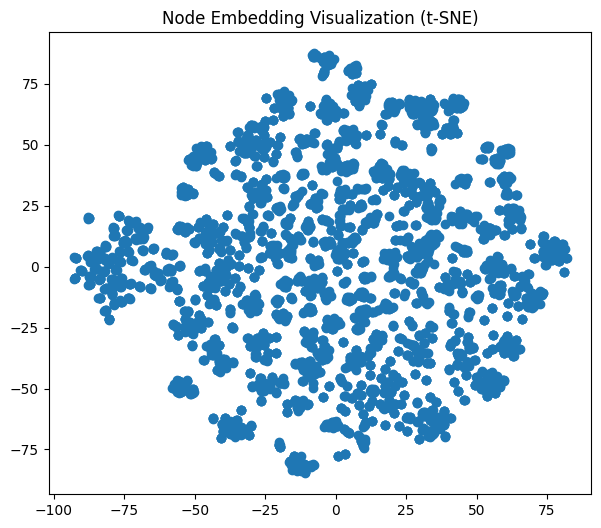

In [19]:
visualize_embeddings(z)

### Test sematic search

In [37]:
def semantic_search_benh(query_benh, idx_to_node, z, top_k=5):
    # z: node_embeddings (N, dim)

    # Tìm index của bệnh
    target_idx = None
    for idx, node in idx_to_node.items():
        if node == query_benh:
            target_idx = idx
            break

    if target_idx is None:
        raise ValueError(f"Bệnh '{query_benh}' không tồn tại trong graph!")

    query_emb = z[target_idx].unsqueeze(0)  # (1, dim)

    # Cosine similarity toàn bộ node
    sims = F.cosine_similarity(query_emb, z)

    # Lấy top-k cao nhất
    top_idx = sims.topk(top_k + 1).indices.tolist()  # +1 để bỏ chính nó

    results = []
    for idx in top_idx:
        if idx != target_idx:
            results.append((idx_to_node[idx], sims[idx].item()))

    return results[:top_k]


In [38]:
node_to_idx = {node: i for i, node in enumerate(Graph.nodes())}
idx_to_node = {i: node for node, i in node_to_idx.items()}

TypeError: 'property' object is not callable

In [ ]:
results = semantic_search_benh(
    query_benh="thán thư",
    idx_to_node=idx_to_node,
    z=z,
    top_k=5
)

# Test search v2

In [3]:
from google import genai

In [4]:
def extract_entities_and_relationships(text):
    # Initialize the OpenAI client
    # text = sample
    client = genai.Client(api_key="your_api_key")

    prompt = (
        f"You are the query-analysis system for a plant disease diagnosis chatbot using RAG + a Knowledge Graph.\n\n"
        f"Your tasks:\n\n"
        f"1. Determine whether the user’s query is related to plant diseases.\n"
        f"    - If the query is NOT related to plant diseases:\n"
        f"        * Return IsPlantDiseaseQuery = 0\n"
        f"        * Directly answer the user’s question in a clear and concise way.\n"
        f"        * Do NOT extract entities or relationships.\n\n"
        f"        * The answer MUST be in Vietnamese  "
        f"    - If the query IS related to plant diseases:\n"
        f"        * Return IsPlantDiseaseQuery = 1\n\n"
        f"2. When IsPlantDiseaseQuery = 1:\n"
        f"    - Extract all relevant entities according to the following node types:\n"
        f"        * TenCay (PlantName)\n"
        f"        * Benh (Disease)\n"
        f"        * NguyenNhan (Cause)\n"
        f"        * TrieuChung (Symptom)\n"
        f"        * DieuTri (Treatment)\n"
        f"    - Extract relationships using the following relationship types:\n"
        f"        * BI_MAC\n"
        f"        * CACH_DIEU_TRI\n"
        f"        * CO_TRIEU_CHUNG\n"
        f"        * CO_ID_BENH\n"
        f"        * CO_NGUYEN_NHAN\n\n"
        f"3. If the query contains multiple symptoms or multiple plant-disease descriptions, extract ALL corresponding entities and relationships.\n\n"
        f"4. All output must be in English and strictly follow the structure below.\n\n"
        f"   Do not add comments, explanations, or extra text.\n\n"
        f"Follow this format:\n\n"
        f"IsPlantDiseaseQuery: {{0 or 1}}\n\n"
        f"If IsPlantDiseaseQuery = 0:\n"
        f"Answer: '{{Your direct answer to the user’s question}}'\n\n"
        f"If IsPlantDiseaseQuery = 1:\n"
        f"Entities:\n"
        f"- {{EntityName}}: {{EntityType}}\n"
        f"...\n\n"
        f"Relationships:\n"
        f"- ({{Entity1}}, {{RelationshipType}}, {{Entity2}})\n"
        f"...\n\n"
        f"--------------------------------------------\n\n"
        f"Text:\n\"{text}\"\n\n"
    )


    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt],
        config={
            "temperature": 1,
            "top_p": 1,
            "max_output_tokens": 2048,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "response_mime_type": "text/plain"
        }
    )
    return response

# f"Extract entities (nodes) and their relationships (edges) from the text below."
#         f"Entities and relationships MUST be in Vietnamese\n"
#         f"Follow this format:\n\n"
#         f"Entities:\n"
#         f"- {{Entity}}: {{Type}}\n\n"
#         f"Relationships:\n"
#         f"- ({{Entity1}}, {{RelationshipType}}, {{Entity2}})\n\n"
#         f"Text:\n\"{text}\"\n\n"
#         f"Output:\nEntities:\n- {{Entity}}: {{Type}}\n...\n\n"
#         f"Relationships:\n- ({{Entity1}}, {{RelationshipType}}, {{Entity2}})\n"


# f"Bạn là hệ thống phân tích truy vấn cho chatbot chuẩn đoán bệnh cây trồng dùng RAG + Knowledge Graph.\n\n"
#         f"Nhiệm vụ:\n\n"
#         f"1. Xác định xem nội dung người dùng cung cấp có liên quan đến bệnh trên cây trồng hay không.\n"
#         f"    - Nếu KHÔNG liên quan đến bệnh cây trồng:\n"
#         f"        * Trả về IsPlantDiseaseQuery = 0\n"
#         f"        * Trả lời trực tiếp câu hỏi của người dùng một cách ngắn gọn, rõ ràng.\n"
#         f"        * Không trích xuất entity hay relationship.\n\n"
#         f"    - Nếu CÓ liên quan đến bệnh cây trồng:\n"
#         f"        * Trả về IsPlantDiseaseQuery = 1\n\n"
#         f"2. Khi IsPlantDiseaseQuery = 1:\n"
#         f"    - Trích xuất đầy đủ các thực thể (entities) theo đúng các loại node sau:\n"
#         f"        * TenCay\n"
#         f"        * Benh\n"
#         f"        * NguyenNhan\n"
#         f"        * TrieuChung\n"
#         f"        * DieuTri\n"
#         f"        * CaseBenh\n"
#         f"    - Trích xuất các mối quan hệ (relationships) theo đúng các loại sau:\n"
#         f"        * BI_MAC\n"
#         f"        * CACH_DIEU_TRI\n"
#         f"        * CO_TRIEU_CHUNG\n"
#         f"        * CO_ID_BENH\n"
#         f"        * CO_NGUYEN_NHAN\n\n"
#         f"3. Nếu có nhiều câu mô tả nhiều triệu chứng → phải trích xuất đầy đủ toàn bộ entities & relationships.\n\n"
#         f"4. Output phải bằng tiếng Việt và tuân thủ đúng structure bên dưới, không thêm bình luận hay giải thích.\n\n"
#         f"----- FORMAT OUTPUT -----\n\n"
#         f"IsPlantDiseaseQuery: {{0 hoặc 1}}\n\n"
#         f"Nếu IsPlantDiseaseQuery = 0:\n"
#         f"Answer: '{{Câu trả lời cho câu hỏi của người dùng}}'\n\n"
#         f"Nếu IsPlantDiseaseQuery = 1:\n"
#         f"Entities:\n"
#         f"- {{EntityName}}: {{EntityType}}\n"
#         f"...\n\n"
#         f"Relationships:\n"
#         f"- ({{Entity1}}, {{RelationshipType}}, {{Entity2}})\n"
#         f"...\n\n"
#         f"--------------------------------------------\n\n"
#         f"Text:\n\"{text}\"\n\n"





In [7]:
query1 = "Cây thanh long bị mủ ở lá và trái của nó còn có những vết màu đen kì lạ"
query2 = "nếu tôi có 1 phương trình bậc 2, làm thế nào để giải phương trình này"

In [9]:
response = extract_entities_and_relationships(query1)

In [12]:
response.text

'IsPlantDiseaseQuery: 1\n\nEntities:\n- Thanh long: TenCay\n- mủ ở lá và trái: TrieuChung\n- vết màu đen kì lạ: TrieuChung\n\nRelationships:\n- (Thanh long, CO_TRIEU_CHUNG, mủ ở lá và trái)\n- (Thanh long, CO_TRIEU_CHUNG, vết màu đen kì lạ)'

In [10]:
import re

def parse_gemini_response(raw_text: str):
    result = {
        "IsPlantDiseaseQuery": None,
        "Answer": None,
        "Entities": [],
        "Relationships": []
    }

    # --- 1. Extract IsPlantDiseaseQuery ---
    match_query = re.search(r"IsPlantDiseaseQuery:\s*(\d+)", raw_text)
    if match_query:
        result["IsPlantDiseaseQuery"] = int(match_query.group(1))

    # --- 2. Extract Answer (only for case 0) ---
    match_answer = re.search(r"Answer:\s*(.+)", raw_text)
    if match_answer:
        result["Answer"] = match_answer.group(1).strip()

    # --- 3. Extract Entities: lines like "- name: Type" ---
    entities_block = re.search(r"Entities:\s*(.*?)\n\n", raw_text, re.DOTALL)
    if entities_block:
        lines = entities_block.group(1).strip().split("\n")
        for line in lines:
            match_entity = re.match(r"-\s*(.+?):\s*(.+)", line.strip())
            if match_entity:
                entity_name = match_entity.group(1).strip()
                entity_type = match_entity.group(2).strip()
                result["Entities"].append({
                    "name": entity_name,
                    "type": entity_type
                })

    # --- 4. Extract Relationships: lines like "- (A, REL, B)" ---
    rel_block = re.search(r"Relationships:\s*(.*)", raw_text, re.DOTALL)
    if rel_block:
        lines = rel_block.group(1).strip().split("\n")
        for line in lines:
            match_rel = re.match(r"-\s*\((.+?),\s*(.+?),\s*(.+?)\)", line.strip())
            if match_rel:
                e1 = match_rel.group(1).strip()
                rel = match_rel.group(2).strip()
                e2 = match_rel.group(3).strip()
                result["Relationships"].append({
                    "entity1": e1,
                    "relationship": rel,
                    "entity2": e2
                })

    return result

In [13]:
parse_gemini_response(response.text)

{'IsPlantDiseaseQuery': 1,
 'Answer': None,
 'Entities': [{'name': 'Thanh long', 'type': 'TenCay'},
  {'name': 'mủ ở lá và trái', 'type': 'TrieuChung'},
  {'name': 'vết màu đen kì lạ', 'type': 'TrieuChung'}],
 'Relationships': [{'entity1': 'Thanh long',
   'relationship': 'CO_TRIEU_CHUNG',
   'entity2': 'mủ ở lá và trái'},
  {'entity1': 'Thanh long',
   'relationship': 'CO_TRIEU_CHUNG',
   'entity2': 'vết màu đen kì lạ'}]}